In [1]:
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("..")
from utils.search_rainfalls import search_rainfalls
from utils.time_series_utils import get_time_series_df, get_compare_by_time_df, check_abnormally_stable_value_station, check_extreme_value_station

In [2]:
df = search_rainfalls()
df.head()

,index,date,start_time,peak_time,end_time,duration minutes,max_rainfall
0,42,2019-06-24,16-0,18-40,19-50,230,98.0
1,56,2019-07-12,7-50,8-40,9-50,120,94.0
2,279,2020-08-01,3-40,5-0,7-10,210,88.0
3,338,2020-10-12,6-10,8-10,9-40,210,82.0
4,243,2020-07-27,10-50,12-20,13-40,170,80.0


In [3]:
strong_rainfalls = df.loc[df["max_rainfall"] > 40]

In [4]:
strong_rainfalls["date"].value_counts()[:10]

2020-10-24    2
2019-06-16    2
2020-08-19    2
2019-04-12    1
2019-05-26    1
2020-05-15    1
2020-04-18    1
2020-05-25    1
2019-07-14    1
2019-06-24    1
Name: date, dtype: int64

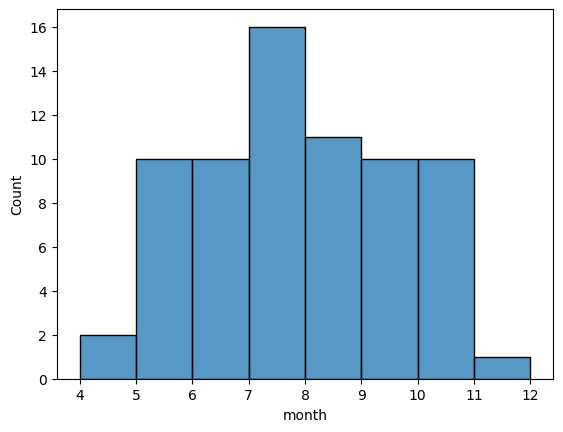

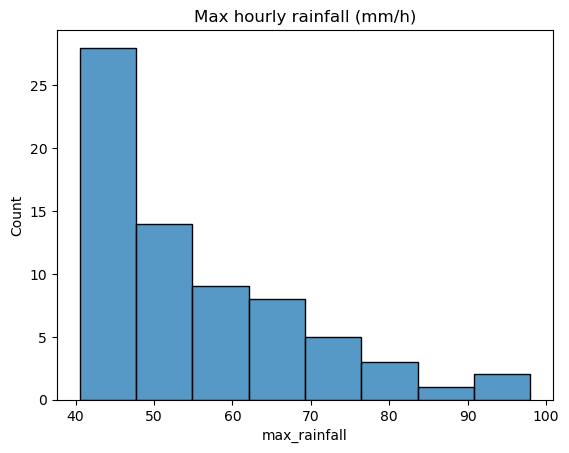

In [5]:
_strong_rainfalls_df = strong_rainfalls.copy(deep=True)
_strong_rainfalls_df["month"] = _strong_rainfalls_df["date"].apply(lambda x: int(x.split("-")[1]))
ax = sns.histplot(_strong_rainfalls_df, x="month")
plt.show()
plt.close()
ax = sns.histplot(_strong_rainfalls_df, x="max_rainfall")
ax.set_title("Max hourly rainfall (mm/h)")
plt.show()
plt.close()

In [6]:
sys.path.append("../../")
from common.utils import timestep_csv_names

_timestep_csv_names = timestep_csv_names(delta=10)
target_data = {}
for idx in strong_rainfalls.index:
    date = strong_rainfalls.loc[idx, "date"]
    peak_time = strong_rainfalls.loc[idx, "peak_time"]
    peak_time_idx = _timestep_csv_names.index(f"{peak_time}.csv")
    # 2 hours before and after of peak_time
    start_idx, end_idx = peak_time_idx - 18, peak_time_idx + 18
    if start_idx < 0 or end_idx > len(_timestep_csv_names) - 1:
        print(f"{date} is skipped. (start: {start_idx}, end: {end_idx})")
        continue
    target_data[date] = {"start_time": _timestep_csv_names[start_idx].replace(".csv", ""), "end_time": _timestep_csv_names[end_idx].replace(".csv", "")}

2020-07-12 is skipped. (start: 114, end: 150)
2019-08-24 is skipped. (start: -10, end: 26)
2019-08-01 is skipped. (start: 119, end: 155)


In [7]:
import pandas as pd


def convert_time_from_int(int_time: int) -> str:
    str_time = str(int_time)
    return str_time[:-2] + ":" + str_time[-2:]


def reset_time_from_str(x: str, str_time_series: list) -> str:
    center_idx = len(str_time_series) // 2
    time_idx = str_time_series.index(x)
    # if time_idx > center_idx:
    #     time = f"t+{10 * (time_idx - center_idx)}"
    # elif time_idx < center_idx:
    #     time = f"t-{10 * (center_idx - time_idx)}"
    # else:
    #     time = 0
    return 10 * (time_idx - center_idx)


data_df = pd.DataFrame(columns=["Time", "ParamName", "Value", "Station_Name", "date"])
for date in target_data.keys():
    year, month, day = date.split("-")
    time_series_df = get_time_series_df(
        one_day_data_dir_path="../../../data/one_day_data",
        year=year,
        month=month,
        date=day,
        start_time=target_data[date]["start_time"],
        end_time=target_data[date]["end_time"],
    )
    compare_df = get_compare_by_time_df(time_series_df, set_zero_start=True)
    # Reset Time
    unique_times = compare_df["Time"].unique()
    sorted_unique_times = sorted([int(t.replace(":", "")) for t in unique_times])
    sorted_unique_times = [convert_time_from_int(t) for t in sorted_unique_times]
    compare_df["Time"] = compare_df["Time"].apply(reset_time_from_str, args=(sorted_unique_times,))
    # Add date col for hue
    compare_df["date"] = date
    data_df = pd.concat([data_df, compare_df], axis=0, ignore_index=True)

In [8]:
target_poteka_params = ["hour-rain", "AT1", "RH1", "WS1", "U-Wind", "V-Wind"]
target_params = ["Hourly rainfall", "Temperature", "Relative Humidity", "Wind Speed", "U-Wind", "V-Wind"]
data_df = data_df.replace(target_poteka_params, target_params)
data_df.head()

,Time,ParamName,Value,Station_Name,date
0,-180,Hourly rainfall,-0.009363,Vlz-Bagbaguin_00174731,2019-06-24
1,-180,Hourly rainfall,0.187260,Vlz-Punturin_00174725,2019-06-24
2,-180,Hourly rainfall,-0.009363,DOST_00174730,2019-06-24
3,-180,Hourly rainfall,-0.009363,MM-Balut_00174728,2019-06-24
4,-180,Hourly rainfall,-0.009363,CAAP_00174729,2019-06-24


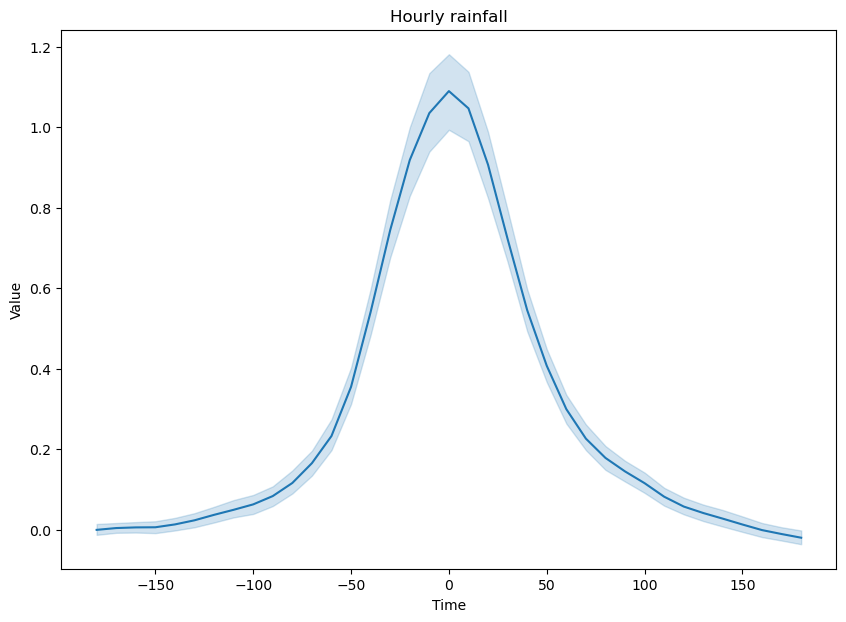

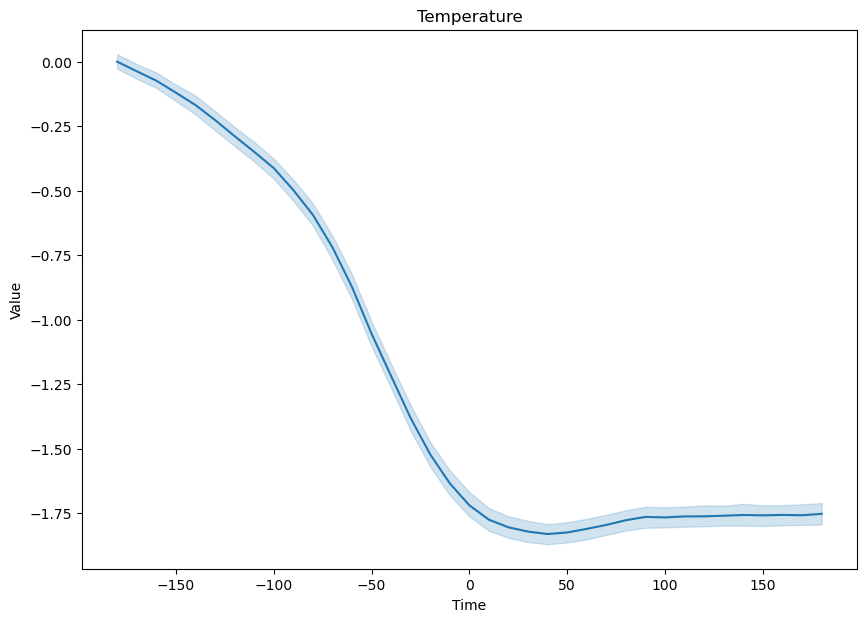

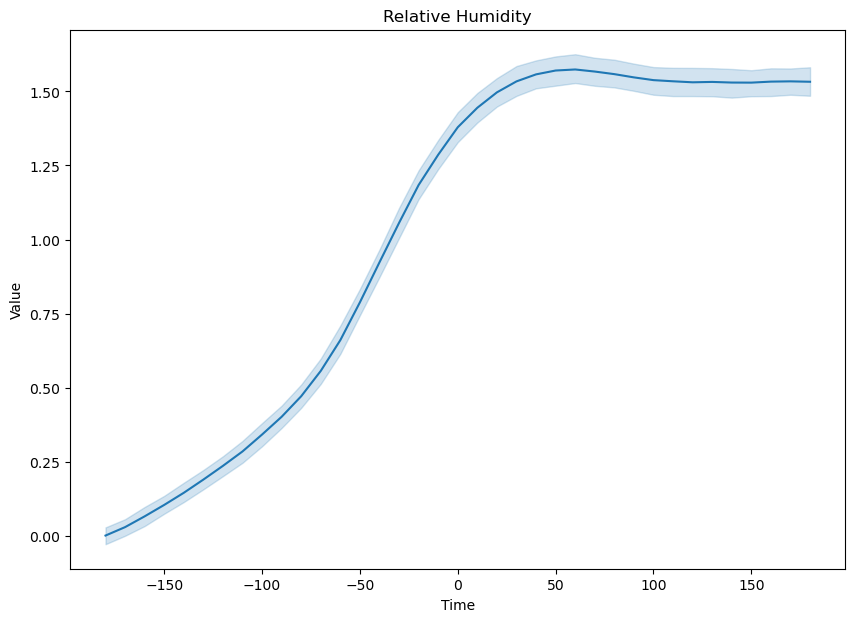

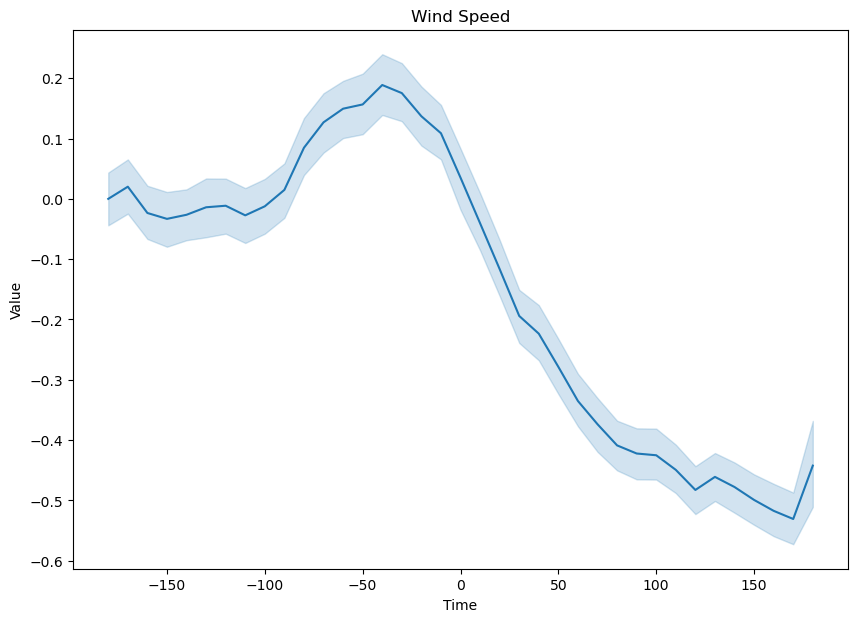

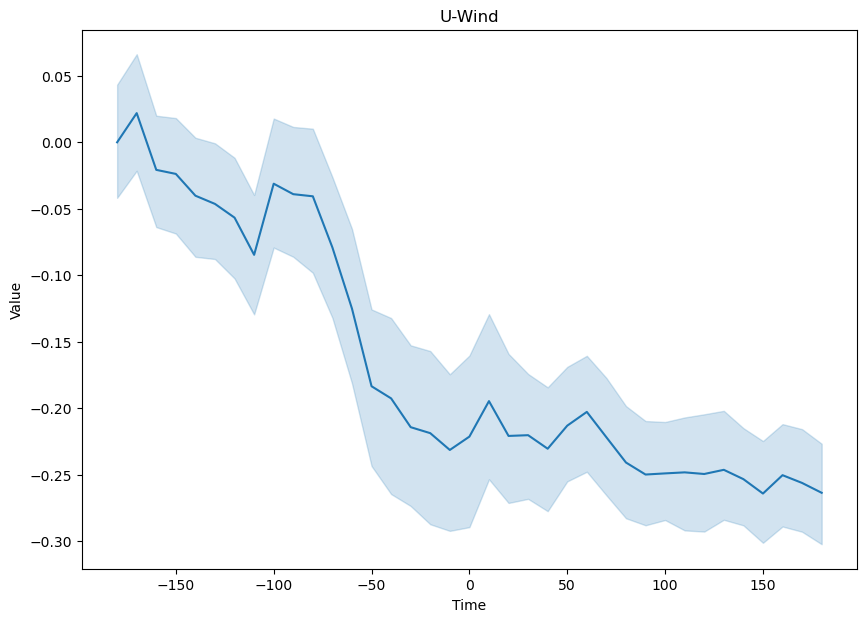

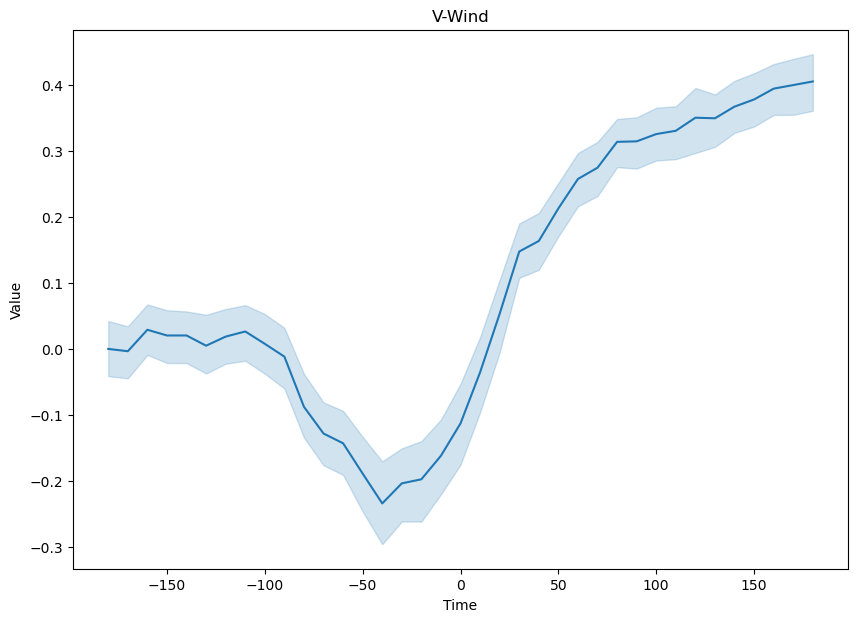

In [9]:
for col in target_params:
    fig, ax = plt.subplots(figsize=(10, 7))
    ax = sns.lineplot(data=data_df.loc[data_df["ParamName"] == col], x="Time", y="Value")
    ax.set_title(col)
    # ax.get_legend().remove()
    plt.show()
    
    plt.close()

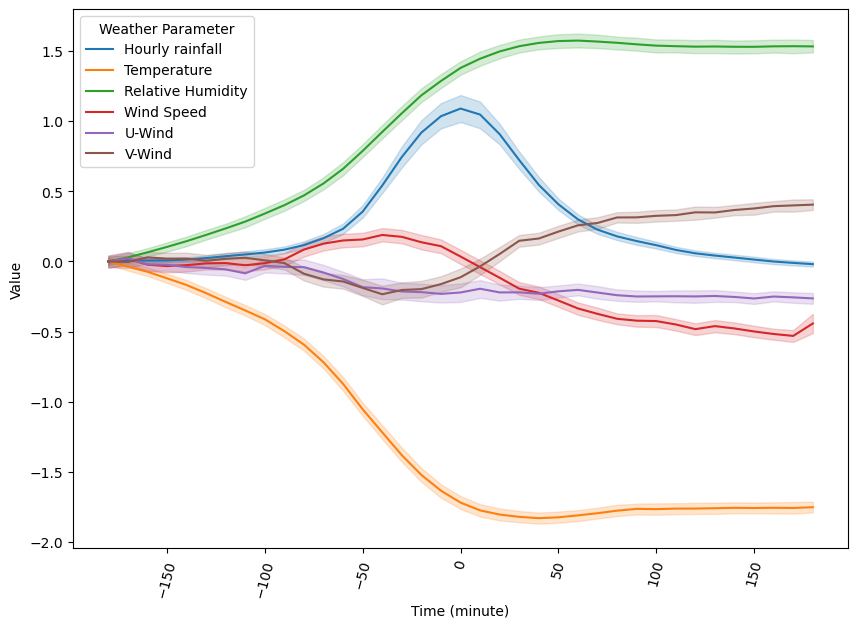

In [57]:
fig, ax = plt.subplots(figsize=(10, 7))
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
target_params = ["Hourly rainfall", "Temperature", "Relative Humidity", "Wind Speed", "U-Wind", "V-Wind"]
ax = sns.lineplot(data=data_df, x="Time", y="Value", hue="ParamName", hue_order=target_params, ax=ax, ci=95)
ax.set_xlabel("Time (minute)")
plt.legend(title='Weather Parameter', loc='upper left')
# ax.legend(["Hourly rainfall", "Temperature", "Relative Humidity", "Wind Speed", "U-Wind", "V-Wind"])
plt.xticks(rotation=75)
plt.show()
plt.close()

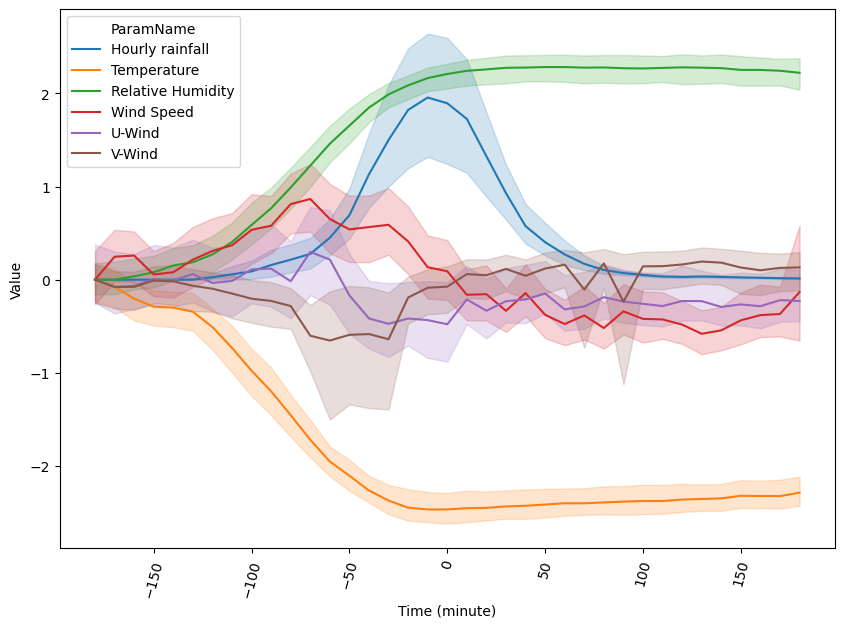

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
ax = sns.lineplot(data=data_df.loc[data_df["date"] == "2020-10-12"], x="Time", y="Value", hue="ParamName", hue_order=target_params, ax=ax)
ax.set_xlabel("Time (minute)")
plt.xticks(rotation=75)
plt.show()
plt.close()

In [12]:
case_df = data_df.loc[data_df["date"] == "2020-10-12"]
case_df.loc[(case_df["Time"] == 180) & (case_df["ParamName"] == "Wind Speed")].describe()

,Time,Value
count,31.0,31.000000
mean,180.0,-0.132966
std,0.0,1.985321
min,180.0,-1.213489
25%,180.0,-0.831579
50%,180.0,-0.640624
75%,180.0,-0.067758
max,180.0,9.849973


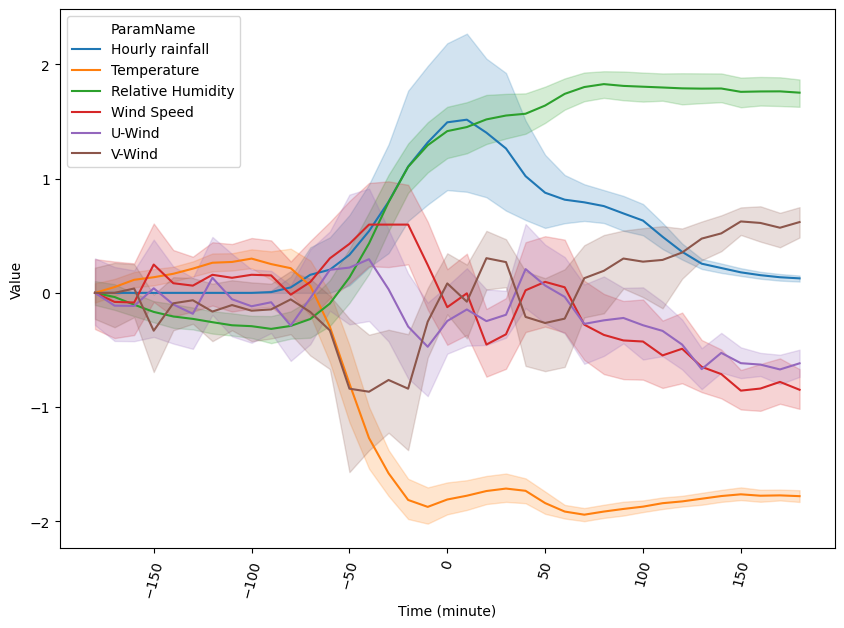

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
ax = sns.lineplot(data=data_df.loc[data_df["date"] == "2020-08-01"], x="Time", y="Value", hue="ParamName", hue_order=target_params, ax=ax)
ax.set_xlabel("Time (minute)")
plt.xticks(rotation=75)
plt.show()
plt.close()

In [52]:
def format_time(t: str):
    t = t.replace('.csv', '').replace('-', ':')
    if t.endswith(':0'):
        t = t.replace(':0', ':00')
    return t

def get_times(date: str):
    peak_time = df.loc[df.date == date].peak_time.tolist()[0]
    start_time_idx = _timestep_csv_names.index(f'{peak_time}.csv')
    return ['{} UTC'.format(format_time(t)) for t in _timestep_csv_names[start_time_idx - 18: start_time_idx + 19]]

print(get_times('2020-09-14'))

['3:00 UTC', '3:10 UTC', '3:20 UTC', '3:30 UTC', '3:40 UTC', '3:50 UTC', '4:00 UTC', '4:10 UTC', '4:20 UTC', '4:30 UTC', '4:40 UTC', '4:50 UTC', '5:00 UTC', '5:10 UTC', '5:20 UTC', '5:30 UTC', '5:40 UTC', '5:50 UTC', '6:00 UTC', '6:10 UTC', '6:20 UTC', '6:30 UTC', '6:40 UTC', '6:50 UTC', '7:00 UTC', '7:10 UTC', '7:20 UTC', '7:30 UTC', '7:40 UTC', '7:50 UTC', '8:00 UTC', '8:10 UTC', '8:20 UTC', '8:30 UTC', '8:40 UTC', '8:50 UTC', '9:00 UTC']


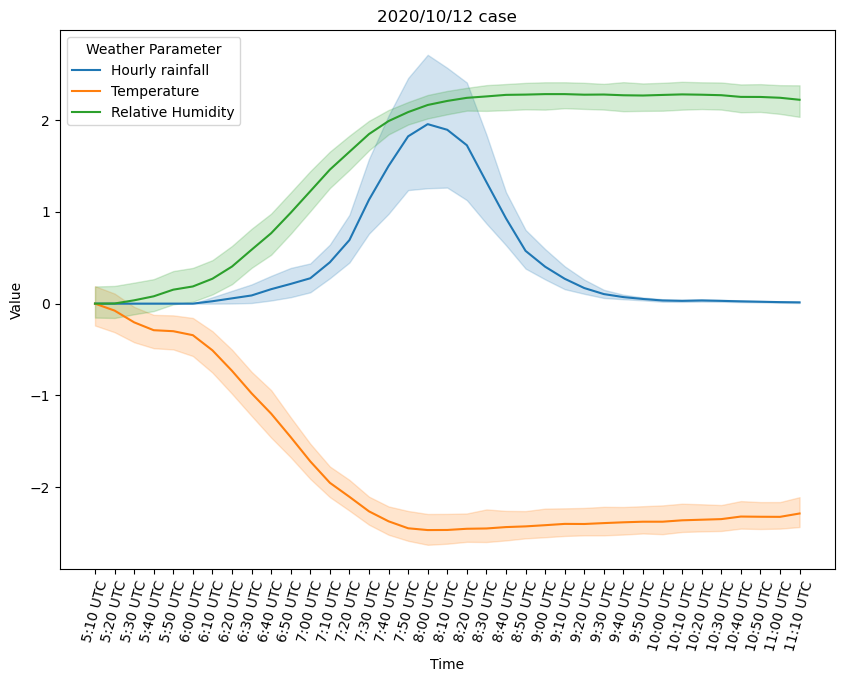

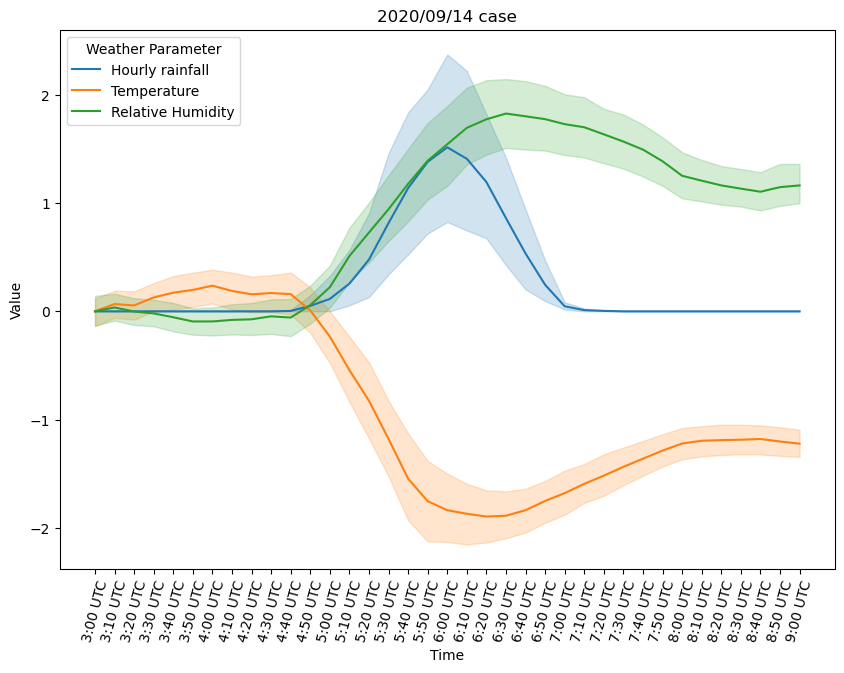

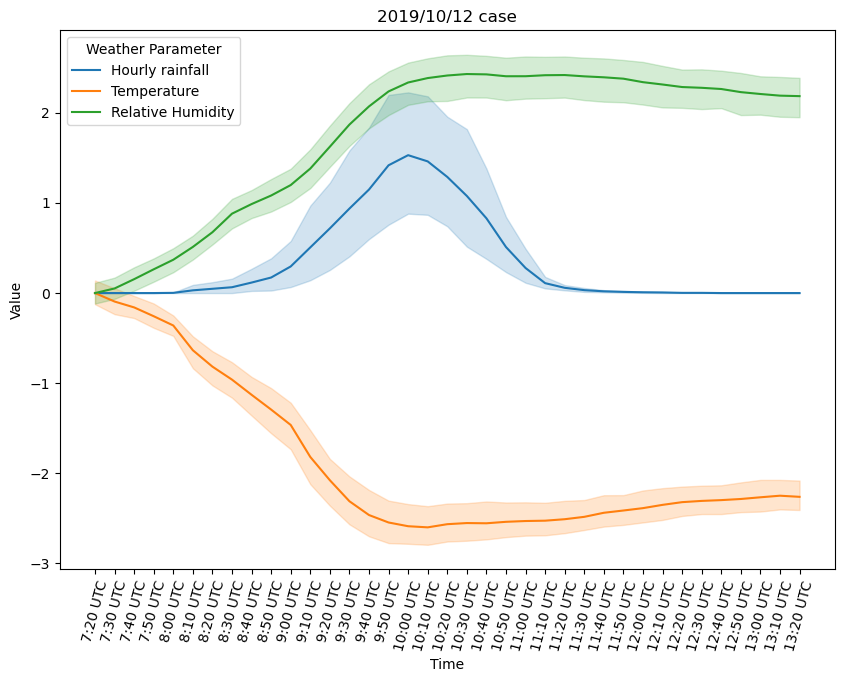

In [55]:
target_params = ["Hourly rainfall", "Temperature", "Relative Humidity"]
target_dates = ["2020-10-12", "2020-09-14", "2019-10-12"]
for date in target_dates:
    fig, ax = plt.subplots(figsize=(10, 7))
    # for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
    #     if station_name not in exclude_observation_points:
    #         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

    # exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
    # compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
    
    target_df = data_df.loc[data_df["date"] == date]
    ax = sns.lineplot(data=target_df, x="Time", y="Value", hue="ParamName", hue_order=target_params, ax=ax)
    ax.set_xlabel("Time")
    plt.xticks(ticks=sorted(target_df.Time.unique().tolist()), labels=get_times(date))
    slash_date = date.replace("-", "/")
    ax.set_title(f"{slash_date} case")
    plt.legend(title='Weather Parameter', loc='upper left', )
    plt.xticks(rotation=75)
    plt.savefig(f"{date}-epoch-analysis.png")
    plt.show()
    plt.close()

In [15]:
data_df["month"] = data_df["date"].apply(lambda x: int(x.split("-")[1]))
data_df.head()

,Time,ParamName,Value,Station_Name,date,month
0,-180,Hourly rainfall,-0.009363,Vlz-Bagbaguin_00174731,2019-06-24,6
1,-180,Hourly rainfall,0.187260,Vlz-Punturin_00174725,2019-06-24,6
2,-180,Hourly rainfall,-0.009363,DOST_00174730,2019-06-24,6
3,-180,Hourly rainfall,-0.009363,MM-Balut_00174728,2019-06-24,6
4,-180,Hourly rainfall,-0.009363,CAAP_00174729,2019-06-24,6


<AxesSubplot:xlabel='month', ylabel='Count'>

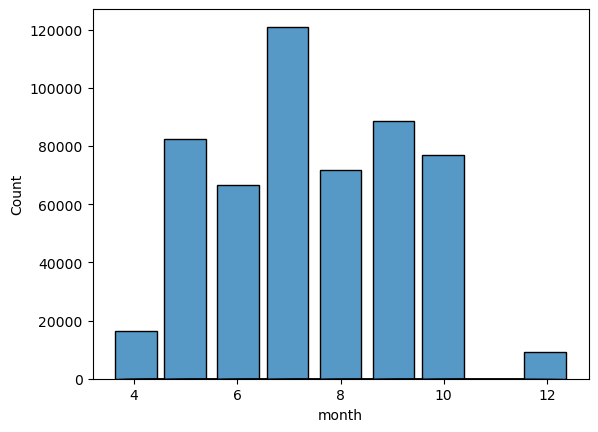

In [16]:
sns.histplot(data=data_df, x="month", shrink=11)

In [17]:
wind_df = pd.read_parquet("../../../data/one_day_data/2019/10/2019-10-04/5-30.parquet.gzip")
wind_df.head(40)

,Unnamed: 0,LON,LAT,hour-rain,AT1,RH1,SOL,WD1,WS1,PRS,SLP
0,Vlz-Bagbaguin_00174731,121.0009,14.7134,0.0,33.0,38.2,266.0,215.0,0.7,1007.6,1011.6
1,DLSAU_00174722,120.9974,14.6705,0.0,34.0,44.7,748.0,252.0,0.3,1007.8,1011.1
2,ASTI_00173457,121.0721,14.6471,0.0,30.8,47.8,352.0,111.0,1.8,1002.6,1009.6
3,MM-SanAndres_00173459,121.0061,14.5837,0.0,32.9,44.5,329.0,177.0,1.4,1008.5,1009.1
4,Vlz-DRRMO_00174734,120.9683,14.6934,0.0,35.2,36.0,820.0,259.0,1.2,1007.7,1009.5
5,UniManila_00181287,120.9815,14.5917,0.0,33.6,46.4,641.0,278.0,1.2,1007.4,1013.1
6,Vlz-Ugong_00174727,121.0086,14.6941,0.0,33.6,41.1,518.0,282.0,0.6,1006.9,1010.5
7,MM-Catmon_00174723,120.9552,14.6706,0.0,33.8,47.1,812.0,14.0,0.7,1009.3,1010.1
8,E-Library_00181274,121.0666,14.5467,0.0,31.1,49.1,159.0,203.0,0.8,1007.7,1008.6
9,RAVE_00181290,121.0974,14.5729,0.0,31.0,40.7,207.0,226.0,0.3,1009.3,1011.4


In [18]:
ws1_outlier_threshold = wind_df["WS1"].quantile(0.98)
wind_df.loc[wind_df["WS1"] > ws1_outlier_threshold, "WS1"] = wind_df["WS1"].quantile(0.95)
wind_df.head(40)

,Unnamed: 0,LON,LAT,hour-rain,AT1,RH1,SOL,WD1,WS1,PRS,SLP
0,Vlz-Bagbaguin_00174731,121.0009,14.7134,0.0,33.0,38.2,266.0,215.0,0.7,1007.6,1011.6
1,DLSAU_00174722,120.9974,14.6705,0.0,34.0,44.7,748.0,252.0,0.3,1007.8,1011.1
2,ASTI_00173457,121.0721,14.6471,0.0,30.8,47.8,352.0,111.0,1.8,1002.6,1009.6
3,MM-SanAndres_00173459,121.0061,14.5837,0.0,32.9,44.5,329.0,177.0,1.4,1008.5,1009.1
4,Vlz-DRRMO_00174734,120.9683,14.6934,0.0,35.2,36.0,820.0,259.0,1.2,1007.7,1009.5
5,UniManila_00181287,120.9815,14.5917,0.0,33.6,46.4,641.0,278.0,1.2,1007.4,1013.1
6,Vlz-Ugong_00174727,121.0086,14.6941,0.0,33.6,41.1,518.0,282.0,0.6,1006.9,1010.5
7,MM-Catmon_00174723,120.9552,14.6706,0.0,33.8,47.1,812.0,14.0,0.7,1009.3,1010.1
8,E-Library_00181274,121.0666,14.5467,0.0,31.1,49.1,159.0,203.0,0.8,1007.7,1008.6
9,RAVE_00181290,121.0974,14.5729,0.0,31.0,40.7,207.0,226.0,0.3,1009.3,1011.4
